In [1]:
import numpy as np
import torch
import torch.distributions as dist
import torch.nn as nn
import matplotlib.pyplot as plt


# phi = torch.tensor([phi_loc, psi_loc])
# kappa = torch.tensor([phi_concentration, psi_concentration])
# lam = torch.tensor([[0.0, correlation], [correlation, 0.0]])

# phi = torch.tensor([0.0, np.pi/2])
# kappa = torch.tensor([10.0, 10.0])
# lam = torch.tensor([[0.0, 0.], [0., 0.0]])

phi = torch.tensor([0.0, np.pi/2])
kappa = torch.tensor([10.0, 10.0])
lam = torch.tensor([[0.0, -10.0], [-10.0, 0.0]])


phi_loc=0.0
psi_loc=np.pi/2
phi_concentration=2.0
psi_concentration=10.0
correlation=-10.0
print(phi, kappa, lam)

class VonMisesProposal(nn.Module):
    def __init__(
        self,
        input_size: torch.Tensor,
        phi: torch.Tensor,
        kappa: torch.Tensor,
        lam: torch.Tensor,
        num_chains: int = 10,
        burn_in: int = 10,
        filter: int = 5,
        **kwargs,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        print("Init Standard Gaussian...")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.phi = nn.Parameter(phi, requires_grad=False)
        self.kappa = nn.Parameter(kappa, requires_grad=False)
        self.lam = nn.Parameter(lam, requires_grad=False)
        assert torch.all(torch.diag(self.lam) == 0)
        self.num_chains = num_chains
        self.burn_in = burn_in
        self.filter = filter

    def sample_simple(self, nb_sample=1):
        samples = []
        # Random init
        x = (
            torch.randn(self.num_chains, self.input_size[0]).to(self.device) % (2 * np.pi)
            - np.pi
        )
        for i in range(self.burn_in + nb_sample):
            for k in range(self.phi.shape[-1]):
                sin_sum = (self.lam[None, k, :]*(torch.sin(x[:,:] - self.phi[None, :]))).sum(-1)
                self.lam[:, k].unsqueeze(0)*(torch.sin(x - self.phi[k].unsqueeze(0)))
                conditional_phi = self.phi[k].unsqueeze(0) + torch.atan2(
                    sin_sum,
                    self.kappa[k].repeat(self.num_chains),
                )
                conditional_kappa = torch.sqrt((self.kappa[k].unsqueeze(0) ** 2 + sin_sum**2))
                x[:, k] = dist.VonMises(conditional_phi, conditional_kappa).sample()
                x[:, k] = (x[:, k] + np.pi) % (2 * np.pi) - np.pi
            if i >= self.burn_in:
                samples.append(x.clone())


        return torch.cat(samples, dim=0)[:nb_sample]

    def log_prob_simple(self, x):
        raise ValueError("The normalisation constant is not None")


/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([0.0000, 1.5708]) tensor([10., 10.]) tensor([[  0., -10.],
        [-10.,   0.]])


Init Standard Gaussian...


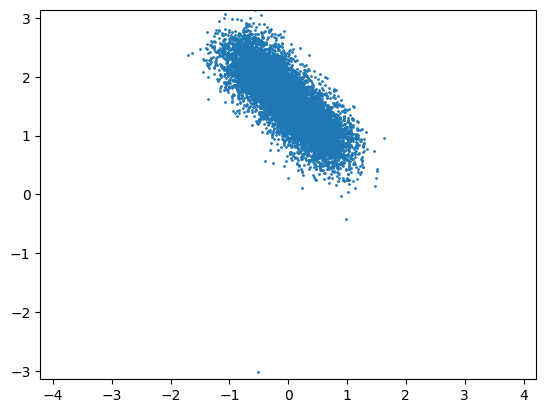

In [2]:
proposal = VonMisesProposal(input_size=torch.Size((2,)), phi=phi, kappa=kappa, lam=lam, num_chains=10, burn_in=10, filter=5)
sample = proposal.sample_simple(10000)

plt.axis('equal')
# Limit axis to -pi, pi
plt.scatter(sample[:, 0], sample[:, 1], s=1)

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
# plt.scatter(sample[:, 0]%2*np.pi - np.pi, sample[:, 1]%2*np.pi - np.pi, s=1)
plt.show()


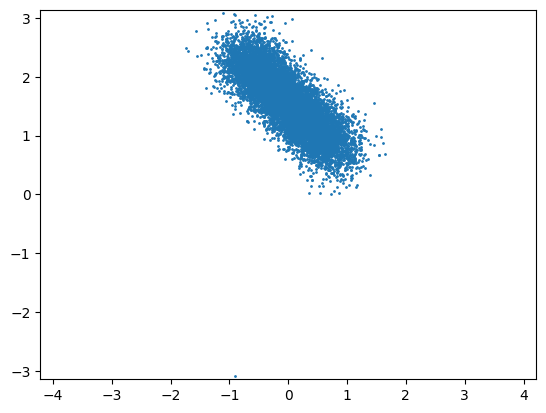

In [3]:
import matplotlib.pyplot as plt 
from numpyro.distributions import SineBivariateVonMises

target_distribution = SineBivariateVonMises(phi_loc = phi[0].item(), psi_loc = phi[1].item(), phi_concentration = kappa[0].item(), psi_concentration = kappa[1].item(), correlation = lam[0, 1].item())

from numpyro import prng_key
from jax import random
rng_key = random.PRNGKey(0)
sample = torch.from_numpy(np.array(target_distribution.sample(key=rng_key, sample_shape=(10000,))))


plt.axis('equal')
# Limit axis to -pi, pi
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
# plt.scatter(sample[:, 0]%2*np.pi - np.pi, sample[:, 1]%2*np.pi - np.pi, s=1)

plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.show()


In [7]:
phi = torch.tensor([0.0, np.pi/2, np.pi])
kappa = torch.tensor([10.0, 10.0, 2.0])

lam = torch.zeros((3,3))
lam[0,1] = 2.
lam[0,2] = 1.0
lam[1,2] = 10.0
lam = (lam + lam.t())

target_distribution = VonMisesProposal(input_size=torch.Size([3]), phi=phi, kappa=kappa, lam=lam)


Init Standard Gaussian...


In [8]:
sample = target_distribution.sample_simple(10000)

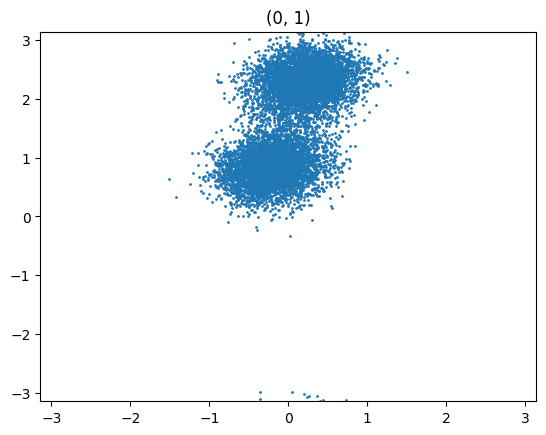

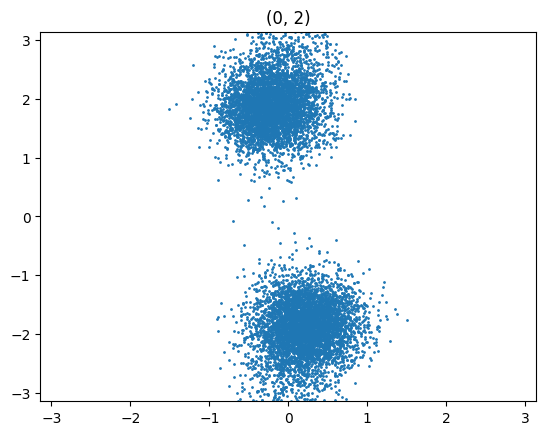

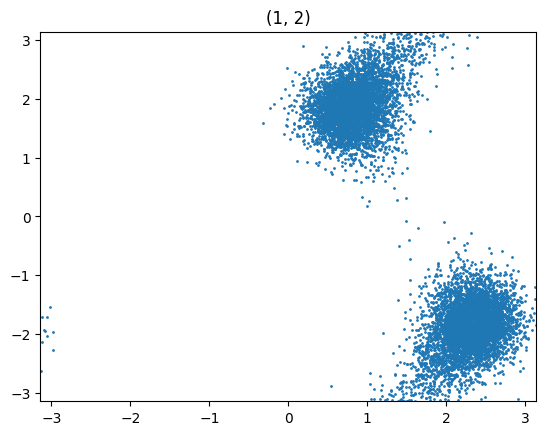

In [9]:
for i in range(3):
    for j in range(i+1, 3):
        plt.scatter(sample[:, i], sample[:, j], s=1)
        plt.xlim(-np.pi, np.pi)
        plt.ylim(-np.pi, np.pi)
        plt.title(f"({i}, {j})")
        plt.show()